## Import Libraries

In [56]:
# data wrangling and exploration
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set()

## Data Wrangling

In [57]:
# import data
crime_df = pd.read_csv('../data/crime-log-geocode-raw.csv')

In [58]:
# check for null values
crime_df.isnull().sum()

case_number              0
time_reported            0
time_started             0
time_ended               0
location_of_occurence    0
domestic_relationship    0
incident_type            0
criminal_offense         0
disposition              0
latitude                 0
longitude                0
dtype: int64

In [59]:
# correct misspelling from original raw data
crime_df = crime_df.rename(columns={'location_of_occurence': 'location_of_occurrence'})

In [60]:
# check for duplicate values
crime_df.duplicated().sum()

5672

In [61]:
# drop duplicates
crime_df = crime_df.drop_duplicates()

# drop "DRAWN IN ERROR" values
crime_df = crime_df.drop(crime_df[crime_df.incident_type == "DRAWN IN ERROR"].index)

# drop "OFFICE INFORMATION" incidents
crime_df = crime_df.drop(crime_df[crime_df.incident_type == "OFFICE INFORMATION (MUPD)"].index)

### Location

In [62]:
# strip whitespace from locations
crime_df.location_of_occurrence = crime_df.location_of_occurrence.str.strip()

# convert "road", "drive", etc to "RD", "DR", etc.
crime_df.location_of_occurrence = crime_df.location_of_occurrence.str.replace("DRIVE, ", 'DR, ', regex=True)
crime_df.location_of_occurrence = crime_df.location_of_occurrence.str.replace("ROAD, ", 'RD, ', regex=True)
crime_df.location_of_occurrence = crime_df.location_of_occurrence.str.replace("STREET, ", 'ST, ', regex=True)


# Some of the zip codes were entered incorrectly, so separate them from the address into their own column
crime_df['zip_code'] = crime_df.location_of_occurrence.str.extract(r'\b(\d{5})')

# delete zip codes from location so that we get a more accurate count of locations
crime_df.location_of_occurrence = crime_df.location_of_occurrence.str.replace(r', \b(\d{5})', '', regex=True)

In [63]:
# check data types for each columns
crime_df.dtypes

case_number                 int64
time_reported              object
time_started               object
time_ended                 object
location_of_occurrence     object
domestic_relationship      object
incident_type              object
criminal_offense           object
disposition                object
latitude                  float64
longitude                 float64
zip_code                   object
dtype: object

### Dates and Times

In [64]:
# convert date columns to datetime
crime_df.time_reported = pd.to_datetime(crime_df.time_reported)
crime_df.time_started = pd.to_datetime(crime_df.time_started)
crime_df.time_ended = pd.to_datetime(crime_df.time_ended)

In [76]:
# create new columns using time_started column. time_started is when the crime occurred
crime_df['year'] = crime_df.time_started.dt.year
crime_df['month'] = crime_df.time_started.dt.month
crime_df['day'] = crime_df.time_started.dt.day
crime_df['hour'] = crime_df.time_started.dt.hour

In [66]:
# reset index 
crime_df = crime_df.reset_index(drop=True)

## Explore the Data

### Criminal Offenses

We can see from the first 20 rows of data that there are several larcenies and assaults each with their own subcategories. Let's check the value counts. It might be better to lump all assaults into one category instead of having multiple subcategories. For example, instead of "ASSAULT - SIMPLE", change it to just "ASSAULT".

In [67]:
crime_df.head(20)

,case_number,time_reported,time_started,time_ended,location_of_occurrence,domestic_relationship,incident_type,criminal_offense,disposition,latitude,longitude,zip_code,year,month,day,hour
0,202300548,2023-04-24 16:56:00,2023-04-24 16:56:00,2023-04-24 16:56:00,"907 HITT ST, COLUMBIA MO",NO,PROPERTY DAMAGE,PROPERTY DAMAGE,ACTIVE,38.939613,-9.232680e+01,65201,2023,4,24,16
1,202300545,2023-04-23 18:26:00,2023-04-23 18:26:00,2023-04-23 18:26:00,"904 ELM ST, COLUMBIA MO",NO,HARASSMENT,HARASSMENT,ACTIVE,38.948217,-9.232689e+01,65211,2023,4,23,18
2,202300544,2023-04-23 10:08:08,2023-04-23 08:08:41,2023-04-23 10:08:08,"1 HOSPITAL DR, COLUMBIA MO",NO,ASSAULT-SIMPLE,ASSAULT-SIMPLE,CLEARED BY ARREST,38.938273,-9.232738e+01,65201,2023,4,23,8
3,202300544,2023-04-23 10:08:08,2023-04-23 08:08:41,2023-04-23 10:08:08,"1 HOSPITAL DR, COLUMBIA MO",NO,OTHER OFFENSE - NOT REPORTABLE,ASSAULT-SIMPLE,CLEARED BY ARREST,38.938273,-9.232738e+01,65201,2023,4,23,8
4,202300542,2023-04-22 23:55:00,2023-04-22 23:55:00,2023-04-22 23:55:00,"399 E STADIUM BLVD, COLUMBIA MO",NO,TRAFFIC OFFENSE,TRAFFIC OFFENSE,CLEARED BY ARREST,38.938349,-9.233316e+01,65203,2023,4,22,23
5,202300542,2023-04-22 23:55:00,2023-04-22 23:55:00,2023-04-22 23:55:00,"399 E STADIUM BLVD, COLUMBIA MO",NO,WARRANT ARREST,TRAFFIC OFFENSE,CLEARED BY ARREST,38.938349,-9.233316e+01,65203,2023,4,22,23
6,202300541,2023-04-22 21:18:00,2023-04-22 21:18:00,2023-04-22 21:18:00,"1 HOSPITAL DR, COLUMBIA MO",NO,ASSAULT-SIMPLE,ASSAULT-SIMPLE,CLEARED BY ARREST,38.938273,-9.232738e+01,65201,2023,4,22,21
7,202300540,2023-04-22 10:23:00,2023-04-22 10:23:00,2023-04-22 10:23:00,"1 HOSPITAL DR, COLUMBIA MO",NO,LARCENY - SHOPLIFTING,LARCENY - SHOPLIFTING,EXCEPTIONALLY CLEARED,38.938273,-9.232738e+01,65201,2023,4,22,10
8,202300539,2023-04-22 07:22:00,2023-04-22 07:22:00,2023-04-22 07:22:00,"115 MIZZOU NORTH, COLUMBIA MO",NO,LARCENY - THEFT FROM BUILDING,LARCENY - THEFT FROM BUILDING,ACTIVE,38.967138,-9.233914e+01,65201,2023,4,22,7
9,202300538,2023-04-22 01:06:00,2023-04-22 01:06:00,2023-04-22 01:06:00,"949 CONLEY AVE, COLUMBIA MO",NO,TRAFFIC OFFENSE,TRAFFIC OFFENSE,CLEARED BY ARREST,0.168257,9.087286e+07,65201,2023,4,22,1


In [68]:
# value count for criminal_offense
crime_df.criminal_offense.value_counts().head(10)

FORGERY                     1441
DRUG - NARCOTIC             1273
TRAFFIC OFFENSE              567
LIQUOR LAW                   539
DWI                          533
ASSAULT-SIMPLE               428
CRASH INVESTIGATION          425
LARCENY - OTHER              412
PROPERTY DAMAGE              392
SICK/MENTALLY ILL PERSON     267
Name: criminal_offense, dtype: int64

I thought there would be more larceny offenses. What happens if we combine all subcategories of larceny into one large category? Let's do the same for other criminal offenses as well. We can keep the original column for more detail and create a new column for the general category.

In [69]:
# check number of larceny incidents
crime_df.query('criminal_offense.str.contains("LARCENY")').shape

(853, 16)

As you can see, if we filter the dataframe for all offenses that are larceny, it returns 853 incidents. In the original value count, this would have made it a top 3 crime. Let's go ahead and put all incidents into their respective general categories and check the results.

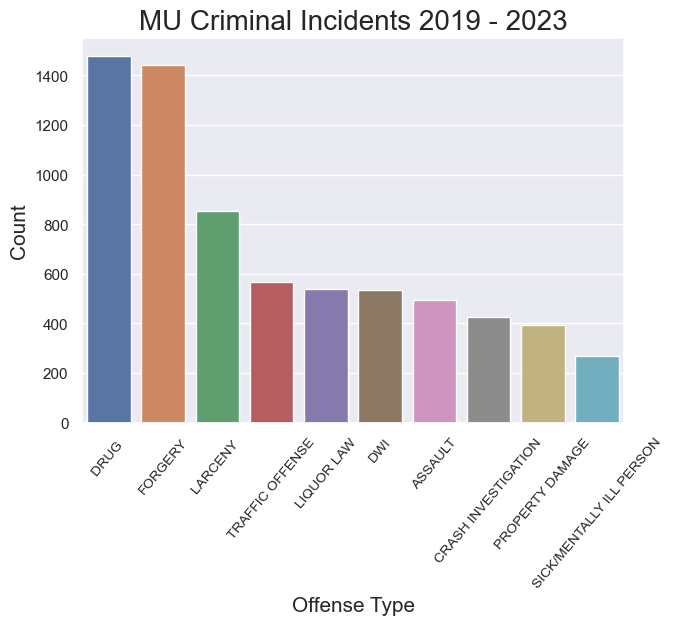

In [70]:
# create new column of a generalization of criminal offenses
crime_df['general_offense'] = crime_df.criminal_offense.str.replace(r'-.*', '', regex=True)

# plot top 10 criminal incidents
temp_df = crime_df.general_offense.value_counts().head(10)
plt.figure(figsize=(7, 5))
plt.title('MU Criminal Incidents 2019 - 2023', fontsize=20)
plt.xticks(rotation=50, fontsize=10)
plt.xlabel('Offense Type', fontsize=15)
plt.ylabel('Count', fontsize=15)
sns.barplot(x=temp_df.index, y=temp_df.values)

plt.show()

### Criminal Activity Locations

In [71]:
# value count for location
crime_df.location_of_occurrence.value_counts().head(10)

1 HOSPITAL DR, COLUMBIA MO           684
3 HOSPITAL DR, COLUMBIA MO           354
901 VIRGINIA AVE, COLUMBIA MO        189
309 HITT ST, COLUMBIA MO             168
1100 S PROVIDENCE RD, COLUMBIA MO    154
1199 E STADIUM BLVD, COLUMBIA MO      93
1099 S PROVIDENCE RD, COLUMBIA MO     89
800 VIRGINIA AVE, COLUMBIA MO         84
999 E STADIUM BLVD, COLUMBIA MO       83
904 S COLLEGE AVE, COLUMBIA MO        83
Name: location_of_occurrence, dtype: int64

A lot of incidents occuring near the hospital. Including "901 Virginia Ave", that is almost 20% of incidents happening near the hospital. It might be worth exploring the types of activities just in that area as compared to all the data.

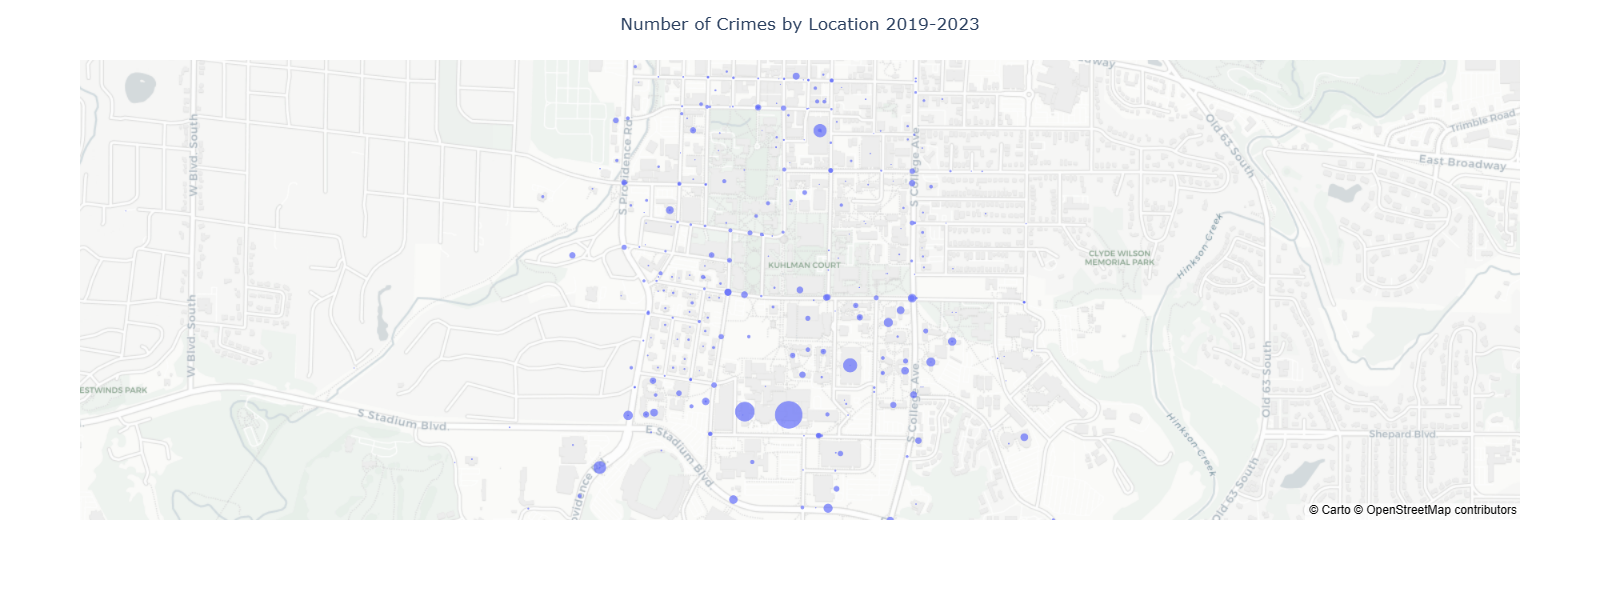

In [107]:
# create a dataframe that has count of number of crimes at each location
temp_df = crime_df.groupby(['latitude', 'longitude', 'location_of_occurrence'], as_index=False).size().sort_values(by='size', ascending=False)

# rename size column to n_crimes
temp_df = temp_df.rename(columns={'size': 'n_crimes'})

# for sake of clearer visualization, filter out locations that have less than 3 crimes
temp_df = temp_df.query('n_crimes > 2')

# new column in temp_df that contains all the info for hovering in map
temp_df['hover_info'] = 'Address: ' + temp_df.location_of_occurrence.astype(str) + '<br>' + 'Num of Crimes: ' + temp_df.n_crimes.astype(str)

# Create heatmap of criminal activity
fig = px.scatter_mapbox(
    temp_df,
    lat='latitude',
    lon='longitude',
    center=dict(lat=38.94244, lon=-92.3269),
    zoom=14,
    size='n_crimes',
    mapbox_style='carto-positron',
    hover_data={'latitude': False, 'longitude': False, 'n_crimes': False},
    hover_name='hover_info',
)

fig.update_layout(width=800, height=600, title='Number of Crimes by Location 2019-2023', title_x=0.5)
fig.show()

There is a lot of activity occurring near the university hospital and near parking garages. Surprisingly, there is a lot of crime happening at 901 Virginia Ave where the MU Police Department is headquartered. Another location of interest is the 309 Hitt Street parking garage with 168 crimes occuring.

### Crime by Time

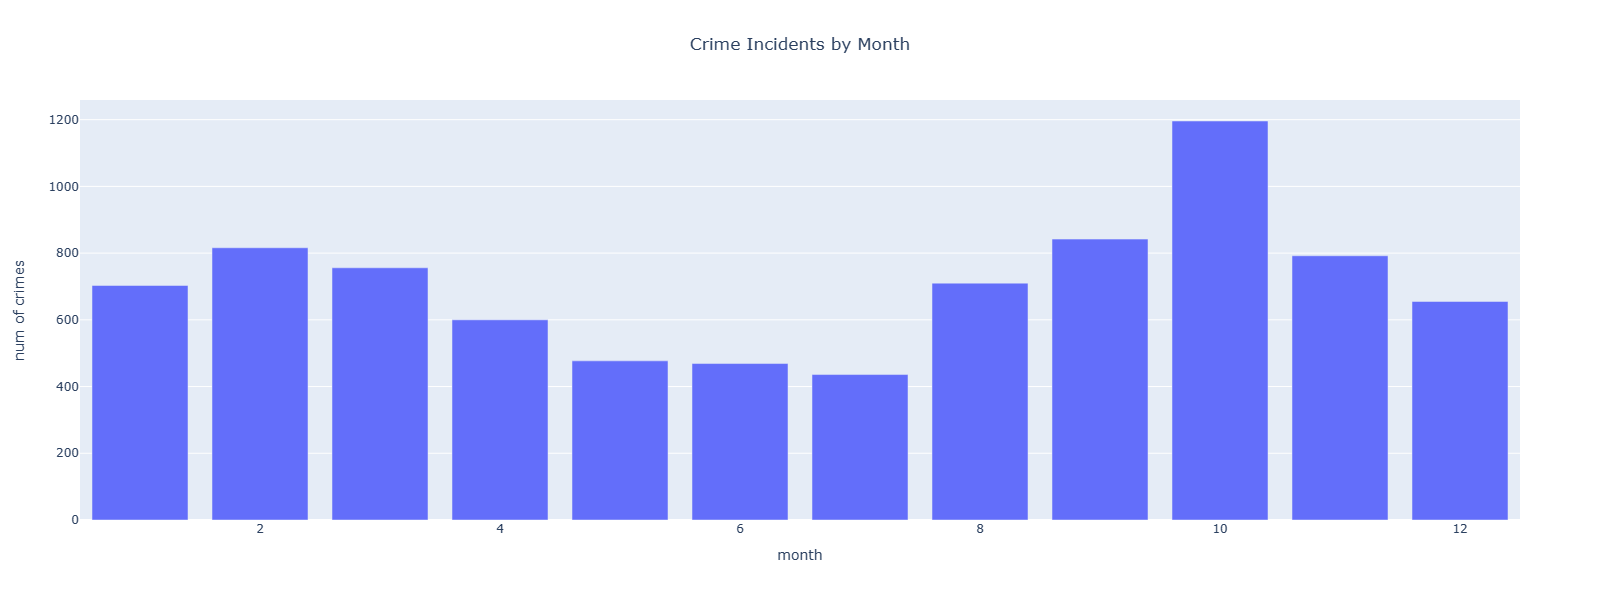

In [111]:
temp_df = crime_df.groupby('month', as_index=False).size()

fig = px.bar(temp_df, x='month', y='size', title='Crime Incidents by Month')

fig.update_layout(width=800, height=600, title_x=0.5, yaxis_title='num of crimes')
# Show the plot
fig.show()

There is typically a large drop off in crime from May through July and December through January, coinciding with summer and winter break for students.